<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [1]:
# Run this before everything
!pip install --upgrade --q tensorflow

     |████████████████████████████████| 421.8MB 32kB/s 
     |████████████████████████████████| 450kB 31.4MB/s 
     |████████████████████████████████| 3.9MB 39.8MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.


In [0]:
from google.colab import drive
import pandas as pd
from pandas import read_csv, to_datetime
import numpy as np
from numpy import array,hstack
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = 10, 5
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime

In [4]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [0]:
# Import the dataset
drop = ['kVAR', 'kW', 'kWh Value','kVARh Value','kWh Actual', 'Max kW','Period', 'No Of Meters', 'kWh Estimate', 'TOU Demand kW', 'TOU Demand kVA', 'PF', 'CO2']

dataset2018 = read_csv(r'2018_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna() # Take into account DST
dataset2019 = read_csv(r'2019_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna()
dataset2017 = read_csv(r'2017_Armidale.csv', header = 0).drop(columns = drop).rename(columns = {"Minimum Temperature": "Temp"}).dropna()
datasetAll = pd.concat([dataset2017, dataset2018, dataset2019], axis=0, sort = False, ignore_index= True)

# Scalers for datasetAll.
s_demand = MinMaxScaler()
s_temp = MinMaxScaler()
datasetAll['Demand kVA_s'] =  s_demand.fit_transform(datasetAll[['Demand kVA']])
datasetAll['Temp'] = s_temp.fit_transform(datasetAll[['Temp']])
datasetAll['Out'] = datasetAll['Demand kVA_s']
datasetAll = datasetAll[['Demand kVA_s', 'Temp', 'Out']].dropna()

In [0]:
datasetAll
su17 = datasetAll.loc[0:5663]
au17 = datasetAll.loc[5664:14495]
wi17 = datasetAll.loc[14496:23327]
sp17 = datasetAll.loc[23328:32059]
su18 = datasetAll.loc[32060:40699]
au18 = datasetAll.loc[40700:49531]
wi18 = datasetAll.loc[49532:58363]
sp18 = datasetAll.loc[58364:67095]
su19 = datasetAll.loc[67096:75735]
au19 = datasetAll.loc[75736: 84567]
wi19 = datasetAll.loc[84568: 93399]
sp19 = datasetAll.loc[93400:102131]
su20 = datasetAll.loc[102132:]

In [8]:
datasetAll

,Demand kVA_s,Temp,Out
0,0.185116,0.692671,0.185116
1,0.196271,0.692671,0.196271
2,0.215068,0.692671,0.215068
3,0.267207,0.692671,0.267207
4,0.254273,0.680851,0.254273
...,...,...,...
105103,0.203781,0.647754,0.203781
105104,0.200126,0.628842,0.200126
105105,0.211051,0.628842,0.211051
105106,0.208086,0.643026,0.208086


In [9]:
def split_dataset(dataset, fraction = 0.7):
  ## Split the dataset into train and test set ##
  train_size = int(len(dataset) * fraction)
  test_size = len(dataset) - train_size
  train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train_data, test_data

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import *
print(tensorflow.__version__)

2.1.0


In [0]:
##### TRAIN
in_seq1 = array(su17.append(su18, ignore_index= True).append(su19, ignore_index = True)['Temp'].values)
in_seq2 = array(su17.append(su18, ignore_index= True).append(su19, ignore_index = True)['Demand kVA_s'].values)
out_seq = array(su17.append(su18, ignore_index= True).append(su19, ignore_index = True)['Out'].values)
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

dataset = hstack((in_seq1, in_seq2, out_seq))

n_steps_in= 20
n_steps_out = 13 #include the current value

# split dataset into train and test set
X_train, y_train = split_sequences(dataset, n_steps_in, n_steps_out)

###### TEST
in_seq1 = array(su20['Temp'].values)
in_seq2 = array(su20['Demand kVA_s'].values)
out_seq = array(su20['Out'].values)
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

dataset = hstack((in_seq1, in_seq2, out_seq))
X_test, y_test = split_sequences(dataset, n_steps_in, n_steps_out)

Train on 18330 samples, validate on 4583 samples
Epoch 1/100
18330/18330 - 13s - loss: 0.0084 - val_loss: 0.0107
Epoch 2/100
18330/18330 - 10s - loss: 0.0051 - val_loss: 0.0082
Epoch 3/100
18330/18330 - 10s - loss: 0.0044 - val_loss: 0.0076
Epoch 4/100
18330/18330 - 10s - loss: 0.0040 - val_loss: 0.0066
Epoch 5/100
18330/18330 - 10s - loss: 0.0038 - val_loss: 0.0060
Epoch 6/100
18330/18330 - 10s - loss: 0.0037 - val_loss: 0.0057
Epoch 7/100
18330/18330 - 10s - loss: 0.0036 - val_loss: 0.0054
Epoch 8/100
18330/18330 - 10s - loss: 0.0035 - val_loss: 0.0054
Epoch 9/100
18330/18330 - 10s - loss: 0.0034 - val_loss: 0.0052
Epoch 10/100
18330/18330 - 10s - loss: 0.0034 - val_loss: 0.0052
Epoch 11/100
18330/18330 - 10s - loss: 0.0033 - val_loss: 0.0049
Epoch 12/100
18330/18330 - 10s - loss: 0.0033 - val_loss: 0.0048
Epoch 13/100
18330/18330 - 10s - loss: 0.0032 - val_loss: 0.0046
Epoch 14/100
18330/18330 - 10s - loss: 0.0032 - val_loss: 0.0047
Epoch 15/100
18330/18330 - 10s - loss: 0.0031 - va

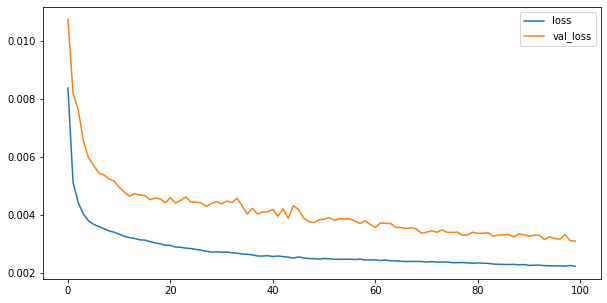

In [78]:
def build_model(X_train, y_train, n_steps_in, n_steps_out, epochs, verbose): 
  ## Build an LSTM model ##
    # Define model
    model = Sequential()
    model.add(LSTM(20, activation='relu', return_sequences= 1, input_shape=(n_steps_in, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(20, return_sequences= 0))
    #model.add(Dropout(0.5))
    #model.add(LSTM(20, return_sequences = 0))
   
    model.add(Dense(n_steps_out)) 
    
    # Train Model
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, validation_split= 0.2, shuffle = False ,callbacks = [EarlyStopping(patience = 10)])
    
    # Visualise Epoch
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()

    return model, history

model, history = build_model(X_train, y_train, n_steps_in = n_steps_in, n_steps_out = n_steps_out, epochs = 100, verbose = 2)

In [79]:
def RMSE(model, X_test, y_test, n_steps_out, scaler):
  y_hat = scaler.inverse_transform(model.predict(X_test))
  RMSE = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(y_hat.shape[0], y_hat.shape[1])), y_hat, multioutput= 'raw_values'))
  mean_RMSE = sum(RMSE[0:])/ (n_steps_out-1)  
  return y_hat, RMSE, mean_RMSE

y_hat,RMSE, mean_RMSE = RMSE(model, X_test, y_test, n_steps_out, s_demand)

print("Test")
print(RMSE)
print(mean_RMSE)

Test
[ 5.55043732  8.74459878 10.78341551 12.00751643 12.63982268 13.08054697
 13.9998155  14.71654564 15.59327474 16.25318791 16.82572966 17.0954414
 17.61697906]
14.575609300796318


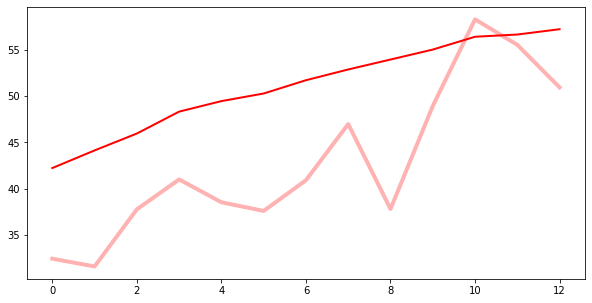

In [102]:
import random
def graphing(y_hat, y_test, scaler):
  i = random.randint(0, y_hat.shape[0]-n_steps_out)
  plt.plot(scaler.inverse_transform(y_test.reshape(y_hat.shape[0], y_hat.shape[1]))[i], label = "Truth", linewidth = 4, color = "red", alpha = 0.3)
  plt.plot(y_hat.reshape(y_hat.shape[0],y_hat.shape[1])[i], color = 'r', linewidth = 2)
  
  
  
  plt.show()

graphing(y_hat, y_test, s_demand)
  

In [0]:
model.save("Armidale_Summer_12_steps_Mul_14.57.h5")